# Introduction

# Part 1 - Modules and Load the Data 

Data from https://nijianmo.github.io/amazon/index.html

In [160]:
# import all modules

import pandas as pd
import json
import gzip
import numpy as np
import matplotlib.pyplot as plt
import themepy
from matplotlib.ticker import MaxNLocator
import nltk
from wordcloud import WordCloud
import string
import re
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc

In [2]:
# load json -> pd.DataFrame

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [3]:
df = getDF('CDs_and_Vinyl_5.json.gz')

# Part 2 - Exploratory Data Analysis

In [4]:
df.head()

,reviewerID,asin,reviewerName,verified,reviewText,overall,reviewTime,summary,unixReviewTime,style,vote,image
0,A1H1DL4K669VQ9,0001393774,Judith Paladino,True,Love it!! Great seller!,5.0,"04 29, 2016",Five Stars,1461888000,NaN,NaN,NaN
1,A3V5XBBT7OZG5G,0001393774,gflady,True,One of my very favourite albums from one of my...,5.0,"02 23, 2016",One of my very favourite albums from one of my...,1456185600,NaN,NaN,NaN
2,A3SNL7UJY7GWBI,0001393774,Lady Leatherneck,True,"THank you Jesus Lord God, that brother Green's...",5.0,"02 11, 2016",Five Stars,1455148800,NaN,NaN,NaN
3,A3478QRKQDOPQ2,0001393774,jacki,True,I recall loving his other albums and maybe thi...,5.0,"11 28, 2015",forgot but I figured on some of these artists ...,1448668800,NaN,NaN,NaN
4,A23M5VTSN2C3H1,0001393774,Caliope,True,Keith Green was a pioneer in the field of Chri...,5.0,"12 16, 2014",and I have loved every album he did,1418688000,NaN,NaN,NaN


In [5]:
df=df[['reviewText','overall']]

In [6]:
df.shape

(1443755, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1443755 entries, 0 to 1443754
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   reviewText  1443475 non-null  object 
 1   overall     1443755 non-null  float64
dtypes: float64(1), object(1)
memory usage: 33.0+ MB


In [8]:
np.sum(df.isnull().any(axis=1))

280

In [9]:
df=df.dropna()

In [10]:
np.sum(df.isnull().any(axis=1))

0

In [11]:
df['overall'].unique()

array([5., 4., 3., 2., 1.])

In [12]:
theme = themepy.Theme()
theme.set_theme()

(theme
 .set_font("Open Sans", color="black") 
 .set_pips(False) 
 .set_spines("off", which=[], color="black") 
 .set_background("#F5F5DC") 
 .set_ticklabel_size(8) 
 .set_plot_colors("#DC5349","#26D8FF","#D3CFBD") 
)
theme.add_theme("pavel_light")
theme.set_theme("pavel_light")

Theme pavel_light successfully overwritten


pavel_light is the active theme

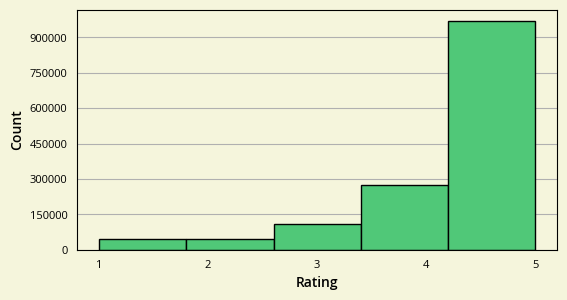

In [13]:
px = 1/plt.rcParams['figure.dpi']
fig, ax = plt.subplots(figsize=(600*px, 300*px))
ax.axis('off')


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)
grid = plt.GridSpec(1, 1,wspace=0, hspace=0)
ax=fig.add_subplot(grid[:, :])

ax.set_facecolor('#F5F5DC')

ax.hist(df['overall'],color="#50C878",alpha=1,linewidth=1,bins=5,edgecolor='black',zorder=2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Rating", fontsize=10,fontweight='medium')
ax.set_ylabel("Count", fontsize=10,fontweight='medium')
ax.grid(axis='y',zorder=1)
ax.tick_params(labelsize=8)

plt.show()

# Part 3 - Data Preparation

In [121]:
df = df[df['overall'] != 3]
df['sentiment']=df['overall'].apply(lambda x: 0 if x<3.0 else 1)
df.head()

,reviewText,overall,sentiment
0,Love it!! Great seller!,5.0,1
1,One of my very favourite albums from one of my...,5.0,1
2,"THank you Jesus Lord God, that brother Green's...",5.0,1
3,I recall loving his other albums and maybe thi...,5.0,1
4,Keith Green was a pioneer in the field of Chri...,5.0,1


In [122]:
df_pos = df[df['sentiment'] == 1]
df_neg = df[df['sentiment'] == 0]

In [123]:
#Creating balanced sample

data_pos = df_pos.iloc[:int(10000)]
data_neg = df_neg.iloc[:int(10000)]

data = pd.concat([data_pos, data_neg])


In [124]:
#Lower letter

data['reviewText']=data['reviewText'].str.lower()
data=data.reset_index()
data['reviewText'].tail()

19995    i have a recent yamaha 6760 sacd/dvd-a player ...
19996    other than 'will you still love me' this album...
19997    i returned the brick to rhino because my onkyo...
19998    i'm a big steely dan fan . i have all their al...
19999    beckers albums tend to go for the same feel as...
Name: reviewText, dtype: object

In [125]:
stopwordlist = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", 
"yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", 
"itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", 
"that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", 
"had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", 
"as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", 
"during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", 
"under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", 
"both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", 
"so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]


In [126]:
#Stopwords - english words that doesn't add much meaning to sentence

def clean_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwordlist])

data['reviewText']=data['reviewText'].apply(lambda x: clean_stopwords(x))
data.head()

,index,reviewText,overall,sentiment
0,0,love it!! great seller!,5.0,1
1,1,one favourite albums one favourite singers. ha...,5.0,1
2,2,"thank jesus lord god, brother green's music st...",5.0,1
3,3,"recall loving albums maybe one too, forgot fig...",5.0,1
4,4,"keith green pioneer field christian rock, love...",5.0,1


In [127]:
#URLS

def clean_urls(text):
    text_no_url=re.sub(r'http\S+', '', text)
    return text_no_url
data['reviewText']=data['reviewText'].apply(lambda x: clean_urls(x))
data.head()

,index,reviewText,overall,sentiment
0,0,love it!! great seller!,5.0,1
1,1,one favourite albums one favourite singers. ha...,5.0,1
2,2,"thank jesus lord god, brother green's music st...",5.0,1
3,3,"recall loving albums maybe one too, forgot fig...",5.0,1
4,4,"keith green pioneer field christian rock, love...",5.0,1


In [128]:
#Punctuations

def clean_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))
data['reviewText']=data['reviewText'].apply(lambda x: clean_punctuations(x))
data.head()

,index,reviewText,overall,sentiment
0,0,love it great seller,5.0,1
1,1,one favourite albums one favourite singers hap...,5.0,1
2,2,thank jesus lord god brother greens music stil...,5.0,1
3,3,recall loving albums maybe one too forgot figu...,5.0,1
4,4,keith green pioneer field christian rock loved...,5.0,1


In [129]:
#Numbers

def clean_numbers(text):
    return ''.join([i for i in text if not i.isdigit()])
data['reviewText']=data['reviewText'].apply(lambda x: clean_numbers(x))
data.head()

,index,reviewText,overall,sentiment
0,0,love it great seller,5.0,1
1,1,one favourite albums one favourite singers hap...,5.0,1
2,2,thank jesus lord god brother greens music stil...,5.0,1
3,3,recall loving albums maybe one too forgot figu...,5.0,1
4,4,keith green pioneer field christian rock loved...,5.0,1


In [130]:
#Defining data to machine learning models

data2=data[['reviewText','sentiment']]
data2['reviewText']=data2['reviewText'].apply(lambda x: x.split())
data2.head()

C:\Users\Paweł Zajdel\AppData\Local\Temp\ipykernel_12300\3357166030.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['reviewText']=data2['reviewText'].apply(lambda x: x.split())


,reviewText,sentiment
0,"[love, it, great, seller]",1
1,"[one, favourite, albums, one, favourite, singe...",1
2,"[thank, jesus, lord, god, brother, greens, mus...",1
3,"[recall, loving, albums, maybe, one, too, forg...",1
4,"[keith, green, pioneer, field, christian, rock...",1


In [132]:
#Stemming - reduces words to its stem

ps = PorterStemmer()
def stemming(words):
    text = [ps.stem(word) for word in words]
    return text
data2['reviewText']=data2['reviewText'].apply(lambda x:  stemming(x))
data2.head()


C:\Users\Paweł Zajdel\AppData\Local\Temp\ipykernel_12300\396252406.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['reviewText']=data2['reviewText'].apply(lambda x:  stemming(x))


,reviewText,sentiment
0,"[love, it, great, seller]",1
1,"[one, favourit, album, one, favourit, singer, ...",1
2,"[thank, jesu, lord, god, brother, green, music...",1
3,"[recal, love, album, mayb, one, too, forgot, f...",1
4,"[keith, green, pioneer, field, christian, rock...",1


In [133]:
positive = data2[data2['sentiment'] == 1]
negative = data2[data2['sentiment'] == 0]

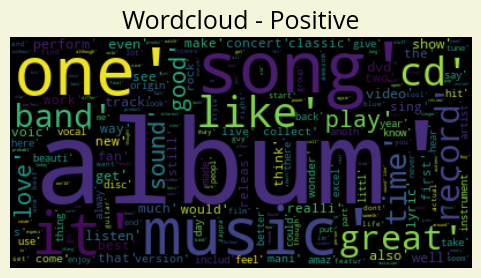

In [157]:
px = 1/plt.rcParams['figure.dpi']
plt.figure(figsize=(600*px, 300*px))

pos = " ".join(str(words) for words in positive['reviewText'])
wordcloud2 = WordCloud().generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('Wordcloud - Positive',fontdict = {'size':18})
plt.axis("off")
plt.show()

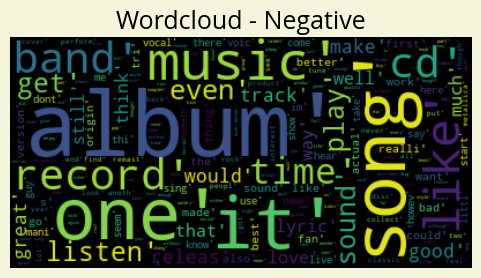

In [156]:
px = 1/plt.rcParams['figure.dpi']
plt.figure(figsize=(600*px, 300*px))

neg = " ".join(str(words) for words in negative['reviewText'])
wordcloud3 = WordCloud().generate(neg)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.title('Wordcloud - Negative',fontdict = {'size':18})
plt.axis("off")
plt.show()

# Part 4 - Model Building & Testing

In [136]:
df2=data[['reviewText','sentiment']]
df2.head()

,reviewText,sentiment
0,love it great seller,1
1,one favourite albums one favourite singers hap...,1
2,thank jesus lord god brother greens music stil...,1
3,recall loving albums maybe one too forgot figu...,1
4,keith green pioneer field christian rock loved...,1


In [137]:
X=df2.reviewText
y=df2.sentiment

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =26105111)

In [139]:
# Creating a bag of words

def tfidf(X_train,X_test):
    tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
    tfidf_vec.fit(X_train)
    X_train_tfidf = tfidf_vec.transform(X_train)
    X_test_tfidf = tfidf_vec.transform(X_test)
    return X_train_tfidf,X_test_tfidf

X_train,X_test=tfidf(X_train,X_test)

In [140]:
X_train.shape

(16000, 500000)

In [141]:
# Logistic Regression

lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [142]:
predictions = lr.predict(X_test)

In [144]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2077
           1       0.89      0.90      0.90      1923

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



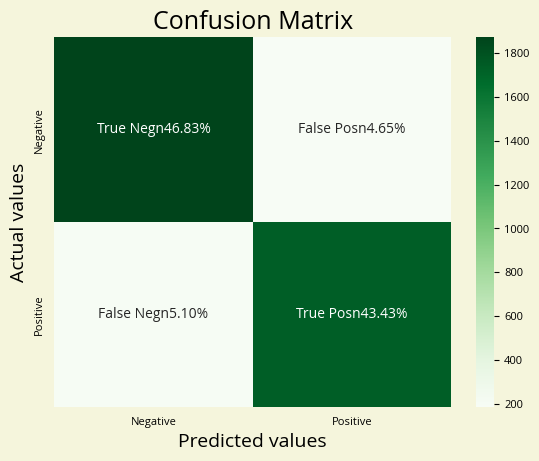

In [159]:
confussion= confusion_matrix(y_test, predictions)
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in confussion.flatten() / np.sum(confussion)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confussion, annot = labels, cmap = 'Greens',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14})
plt.ylabel("Actual values" , fontdict = {'size':14})
plt.title ("Confusion Matrix", fontdict = {'size':18})
plt.show()

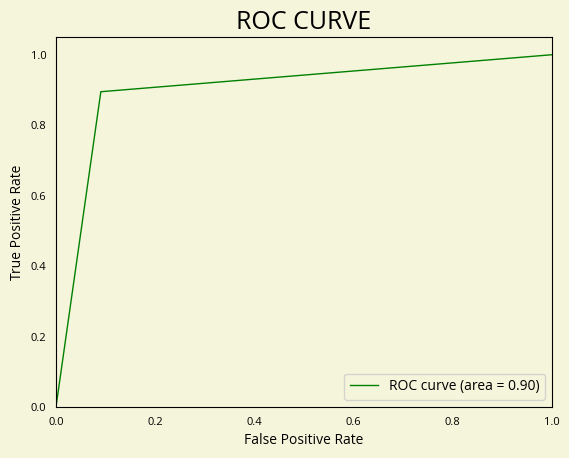

In [162]:
#ROC-AUC curve

fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='green', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE',fontdict = {'size':18})
plt.legend(loc="lower right")
plt.show()

In [148]:
#SVM

SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)

LinearSVC()

In [149]:
predictions2=SVCmodel.predict(X_test)

In [163]:
print(classification_report(predictions2,y_test))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      2033
           1       0.92      0.91      0.91      1967

    accuracy                           0.92      4000
   macro avg       0.92      0.91      0.91      4000
weighted avg       0.92      0.92      0.91      4000



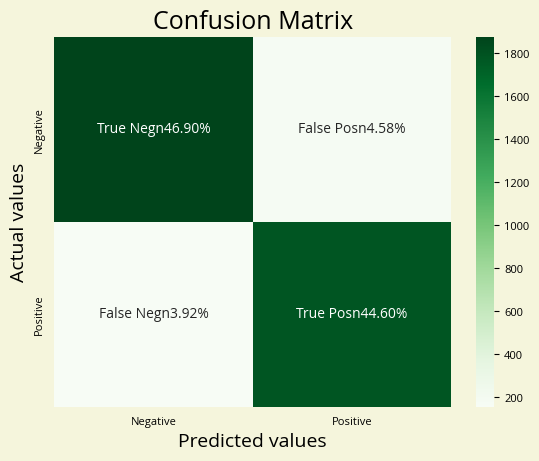

In [164]:
confussion= confusion_matrix(y_test, predictions2)
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in confussion.flatten() / np.sum(confussion)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confussion, annot = labels, cmap = 'Greens',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14})
plt.ylabel("Actual values" , fontdict = {'size':14})
plt.title ("Confusion Matrix", fontdict = {'size':18})
plt.show()

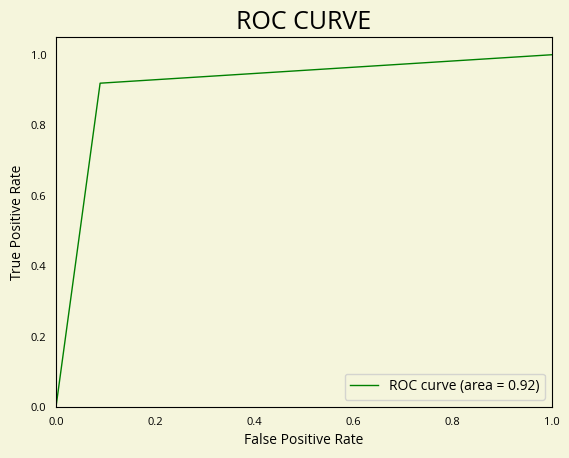

In [165]:
#ROC-AUC curve

fpr, tpr, thresholds = roc_curve(y_test, predictions2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='green', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE',fontdict = {'size':18})
plt.legend(loc="lower right")
plt.show()

# Part 5 - Conclusions

Amongst two models I created, Support Vector Machine performs better than Logistic regression both in accuracy (0.92 to 0.9) and ROC-AUC score (0.92 to 0.90). 
Therefore, I think SVM model is the best fo this specific dataset.